<a href="https://colab.research.google.com/github/YS-05/AnimalClassifier/blob/main/AnimalClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing our libraries, modules and functions that will be needed later on.

In [1]:
import os
import zipfile
import numpy as np
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Zipping the file containing the images.

In [3]:
zip_file = "/content/raw-img.zip"
unzip_dir = "/content/raw-img"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f"Unzipped dataset to {unzip_dir}")

Unzipped dataset to /content/raw-img


Incase we are re-running the code, we can delete animal_dataset since we are creating it again later on.

In [4]:
directory = "/content/animal_dataset"

try:
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Successfully removed the directory: {directory}")
except Exception as e:
    print(f"Error: {e}")

Checking and printing out how many images we have for each animal

In [5]:
source_dir = "/content/raw-img/raw-img"
animal_classes = os.listdir(source_dir)

for animal in animal_classes:
    animal_path = os.path.join(source_dir, animal)
    print(f"There are {len(os.listdir(animal_path))} {animal} images.")

There are 4821 spider images.
There are 2112 butterfly images.
There are 1862 squirrel images.
There are 1820 sheep images.
There are 3098 chicken images.
There are 1446 elephant images.
There are 1866 cow images.
There are 4863 dog images.
There are 2623 horse images.
There are 1668 cat images.


Creating our directory with the training/validation/test files and then creating the sub files as well.

In [6]:
output_dir = "/content/animal_dataset"
train_dir = os.path.join(output_dir, "training")
val_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "test")

os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

animal_classes = os.listdir(source_dir)

for animal in animal_classes:
    an_train_dir = os.path.join(train_dir, animal)
    an_val_dir = os.path.join(val_dir, animal)
    an_test_dir = os.path.join(test_dir, animal)

    os.makedirs(an_train_dir)
    os.makedirs(an_val_dir)
    os.makedirs(an_test_dir)

Creating a function to copy the images from the raw-img file into the correct train/validation/test sets based on the split we want between the sets.

In [7]:
def split_data(source_dir, train_dir, val_dir, test_dir, split_ratio, max_ind_range):
    all_files = os.listdir(source_dir)
    non_empty_files = []
    for x in all_files:
        file_path = os.path.join(source_dir, x)
        if os.path.getsize(file_path) == 0:
            print(f'{x} is 0 length hence ignored')
        else:
            non_empty_files.append(x)

    random_files = random.sample(non_empty_files, max_ind_range)
    ind_change = int(split_ratio * max_ind_range)

    train_files = random_files[:ind_change]
    remain_files = random_files[ind_change:]
    remain_size = len(remain_files) // 2

    valid_files = remain_files[:remain_size]
    test_files = remain_files[remain_size:]

    for file in train_files:
        source_file = os.path.join(source_dir, file)
        destination_file = os.path.join(train_dir, file)
        shutil.copy(source_file, destination_file)

    for file in valid_files:
        source_file = os.path.join(source_dir, file)
        destination_file = os.path.join(val_dir, file)
        shutil.copy(source_file, destination_file)

    for file in test_files:
        source_file = os.path.join(source_dir, file)
        destination_file = os.path.join(test_dir, file)
        shutil.copy(source_file, destination_file)

Using the split_data function to setup our files correctly and ready to be used in the generators.

In [8]:
split_ratio = 0.8
max_ind_range = 1446

main_source_dir = "/content/raw-img/raw-img"
output_dir = "/content/animal_dataset"

train_dir = os.path.join(output_dir, "training")
val_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "test")

animal_classes = os.listdir(main_source_dir)

for animal in animal_classes:
    source_dir = os.path.join(main_source_dir, animal)
    train_class_dir = os.path.join(train_dir, animal)
    val_class_dir = os.path.join(val_dir, animal)
    test_class_dir = os.path.join(test_dir, animal)

    num_files = len([f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))])

    current_max_ind_range = min(max_ind_range, num_files)

    split_data(source_dir, train_class_dir, val_class_dir, test_class_dir, split_ratio, current_max_ind_range)

for animal in animal_classes:
    train_class_dir = os.path.join(train_dir, animal)
    val_class_dir = os.path.join(val_dir, animal)
    test_class_dir = os.path.join(test_dir, animal)

    num_train_files = len(os.listdir(train_class_dir))
    num_val_files = len(os.listdir(val_class_dir))
    num_test_files = len(os.listdir(test_class_dir))

    print(f"{animal} - Training: {num_train_files} images, Validation: {num_val_files} images, Test: {num_test_files} images")

spider - Training: 1156 images, Validation: 145 images, Test: 145 images
butterfly - Training: 1156 images, Validation: 145 images, Test: 145 images
squirrel - Training: 1156 images, Validation: 145 images, Test: 145 images
sheep - Training: 1156 images, Validation: 145 images, Test: 145 images
chicken - Training: 1156 images, Validation: 145 images, Test: 145 images
elephant - Training: 1156 images, Validation: 145 images, Test: 145 images
cow - Training: 1156 images, Validation: 145 images, Test: 145 images
dog - Training: 1156 images, Validation: 145 images, Test: 145 images
horse - Training: 1156 images, Validation: 145 images, Test: 145 images
cat - Training: 1156 images, Validation: 145 images, Test: 145 images


Getting our images ready and rescaled, the training images have been augmented as well.

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode="categorical",
    target_size=(150,150)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    class_mode="categorical",
    target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    class_mode="categorical",
    target_size=(150,150),
    shuffle=False
)

Found 11560 images belonging to 10 classes.
Found 1450 images belonging to 10 classes.
Found 1450 images belonging to 10 classes.


A baseline model to see if we need a more complex model or if this is enough.

In [16]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(256, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

model = create_model()

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,946,570 (26.50 MB)

 Trainable params: 6,946,570 (26.50 MB)

 Non-trainable params: 0 (0.00 B)

Training the model with a patience of 20 to ensure that we aren't overtraining for no reason. Additionally we save the best model to use for the test dataset.

In [17]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min')

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    verbose=1,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 76s 198ms/step - accuracy: 0.1454 - loss: 2.2525 - val_accuracy: 0.3110 - val_loss: 1.9265
Epoch 2/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 70s 191ms/step - accuracy: 0.2667 - loss: 2.0075 - val_accuracy: 0.3731 - val_loss: 1.7915
Epoch 3/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 70s 190ms/step - accuracy: 0.3263 - loss: 1.8611 - val_accuracy: 0.3814 - val_loss: 1.7555
Epoch 4/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 70s 189ms/step - accuracy: 0.3862 - loss: 1.7469 - val_accuracy: 0.4400 - val_loss: 1.5589
Epoch 5/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 70s 191ms/step - accuracy: 0.4202 - loss: 1.6536 - val_accuracy: 0.4545 - val_loss: 1.5550
Epoch 6/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 70s 191ms/step - accuracy: 0.4443 - loss: 1.5760 - val_accuracy: 0.4917 - val_loss: 1.4828
Epoch 7/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 70s 188ms/step - accuracy: 0.4591 - loss: 1.5369 - val_accuracy: 0.4469 - val_loss: 1.5906
Epoch 8/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 71s 192ms/step - accuracy: 0.4671 -

Plotting our accuracy and losses for both the training and validation sets.

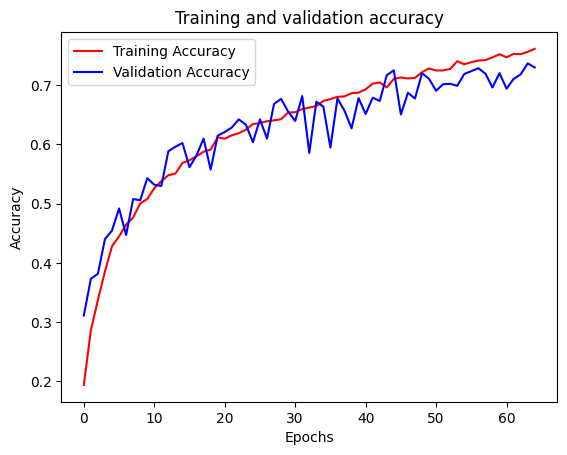

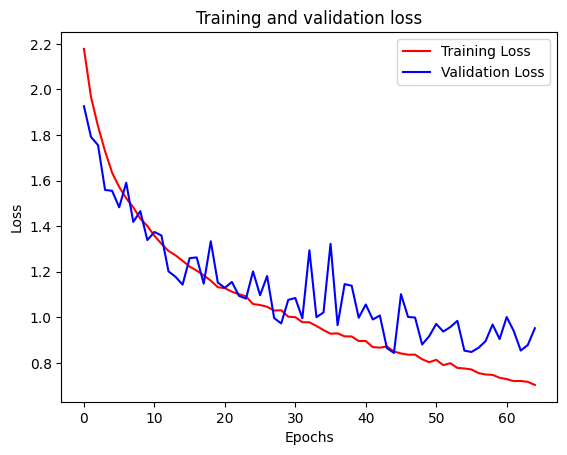

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Calculating our final accuracy and loss using the test set. The results show that while this is solid, there is a lot of room for improvement still. We can't make the model more complex due to larger compute units and time complexity hence we use transfer learning, using the VGG16 model which has been trained to classify 1000 images in 1000 categories. The model was trained for 2-3 weeks on a Nvidia Titan GPU.

In [19]:
best_model = tf.keras.models.load_model('best_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7523 - loss: 0.7434
Test Accuracy: 70.90%
Test Loss: 0.8731


Once again augmenting our train images and this time making sure our images have the shape (224,224) as that is what the VGG16 was trained on.

In [11]:
train_datagen1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen1 = ImageDataGenerator(rescale=1./255)
test_datagen1 = ImageDataGenerator(rescale=1./255)

train_generator1 = train_datagen1.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode="categorical",
    target_size=(224,224)
)

val_generator1 = val_datagen1.flow_from_directory(
    val_dir,
    batch_size=32,
    class_mode="categorical",
    target_size=(224,224)
)
test_generator1 = test_datagen1.flow_from_directory(
    test_dir,
    batch_size=32,
    class_mode="categorical",
    target_size=(224,224),
    shuffle=False
)

Found 11560 images belonging to 10 classes.
Found 1450 images belonging to 10 classes.
Found 1450 images belonging to 10 classes.


Modifying our VGG16 model to fit our criteria. This is done by modifying the top layers and ensuring that our last dense layer will contain 10 filters, one for each animal. We also show the summary of the VGG16 model which contains 13 convolutional layers, 5 pooling layers and 3 dense layers originally but is slightly modified by us.

In [12]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=x)

model_vgg.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate = 0.0001),
                  metrics=['accuracy'])

model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 14,982,474 (57.15 MB)

 Trainable params: 14,982,474 (57.15 MB)

 Non-trainable params: 0 (0.00 B)

Training the model with a patience of 7 to ensure that we don't overtrain while keeping track of the best model based on the least validation loss.

In [13]:
checkpoint = ModelCheckpoint('best_model1.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=7, mode='min')

history1 = model_vgg.fit(
    train_generator1,
    epochs=15,
    validation_data=val_generator1,
    verbose=1,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


362/362 ━━━━━━━━━━━━━━━━━━━━ 165s 397ms/step - accuracy: 0.3811 - loss: 1.7364 - val_accuracy: 0.7662 - val_loss: 0.7141
Epoch 2/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 131s 356ms/step - accuracy: 0.7832 - loss: 0.6563 - val_accuracy: 0.8428 - val_loss: 0.5034
Epoch 3/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 132s 356ms/step - accuracy: 0.8378 - loss: 0.5032 - val_accuracy: 0.8979 - val_loss: 0.3158
Epoch 4/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 130s 352ms/step - accuracy: 0.8703 - loss: 0.4016 - val_accuracy: 0.8786 - val_loss: 0.3711
Epoch 5/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 130s 354ms/step - accuracy: 0.8889 - loss: 0.3352 - val_accuracy: 0.8869 - val_loss: 0.3384
Epoch 6/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 130s 352ms/step - accuracy: 0.9003 - loss: 0.2992 - val_accuracy: 0.9014 - val_loss: 0.3195
Epoch 7/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 132s 357ms/step - accuracy: 0.9165 - loss: 0.2584 - val_accuracy: 0.9179 - val_loss: 0.2489
Epoch 8/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 131s 354ms/step - accuracy: 0.9227 - loss: 0.23

Plotting the performance of the VGG16 model by showing both the accuracy and loss for training and validation sets.

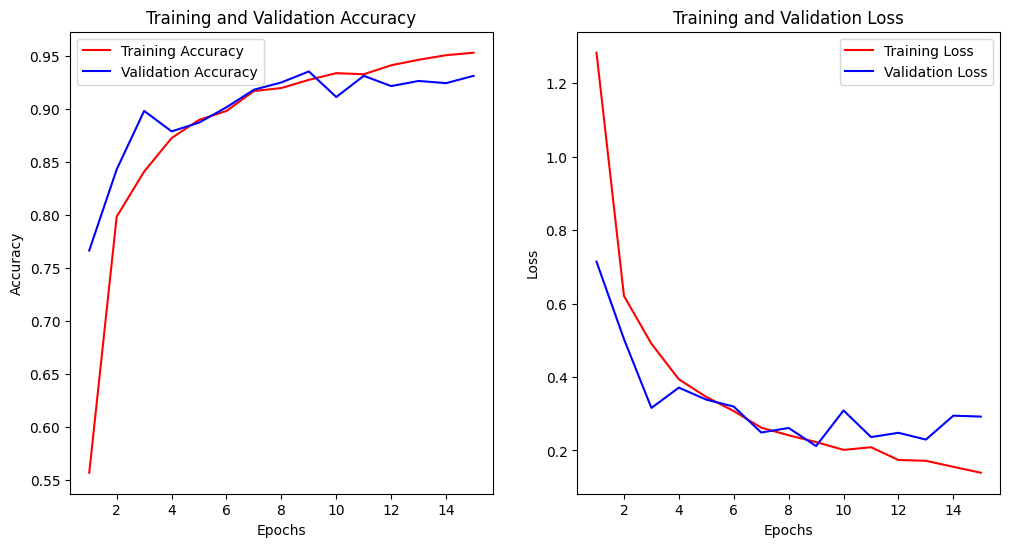

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history1):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the graphs
plot_training_history(history1)

Testing the performance of the best model on the test set to get its final performance accuracy. Which we can see is far better than our base model.

In [15]:
best_model1 = tf.keras.models.load_model('best_model1.keras')

test_loss1, test_accuracy1 = best_model1.evaluate(test_generator1)

print(f"Test Accuracy: {test_accuracy1*100:.2f}%")
print(f"Test Loss: {test_loss1:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9282 - loss: 0.2430
Test Accuracy: 92.90%
Test Loss: 0.2438
